In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla_simulator as jla
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP FOR SIMULATION CODE ###

# Set up the model (imports covariance matrices etc)
JLASimulator = jla.JLA_Model()

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

# Simulator arguments
simulator_args = None

/Users/justinalsing/Dropbox/science/delfi/master/delfi/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
### SET UP THE PRIOR ###

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior_covariance = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
prior_covariance[0,1] = prior_covariance[1,0] = -0.8*0.4*0.75
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Expected data (mean) and covariance
mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt, prior_mean = prior_mean, prior_covariance = prior_covariance)

# Compute the Fisher matrix
Compressor.compute_fisher()

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(JLASimulator.data, compressor_args)

In [6]:
# MDN version
MDN = ndes.MixtureDensityNetwork(n_inputs=6, n_outputs=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results_nofisher/mdn")

In [7]:
# Do the Fisher pre-training
#DelfiMDN.fisher_pretraining()

Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


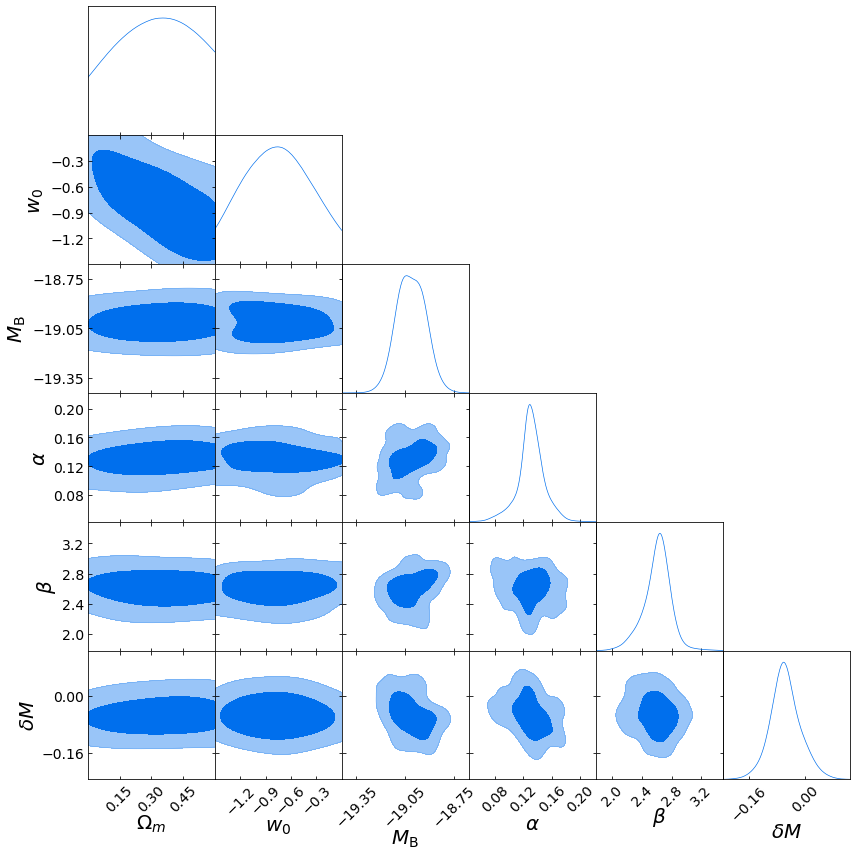

Population 1/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


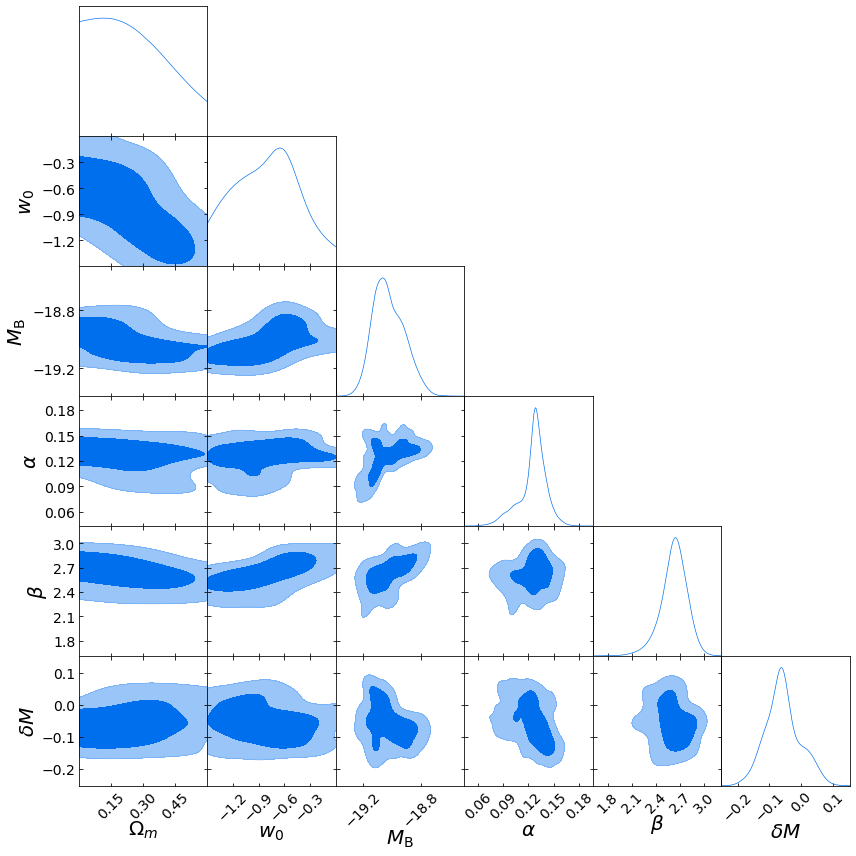

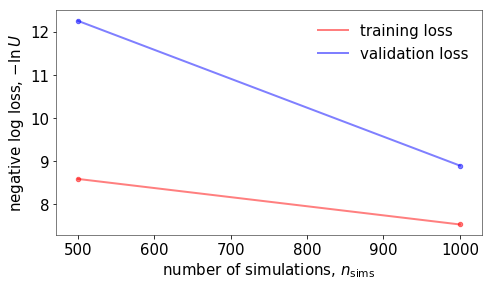

Population 2/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


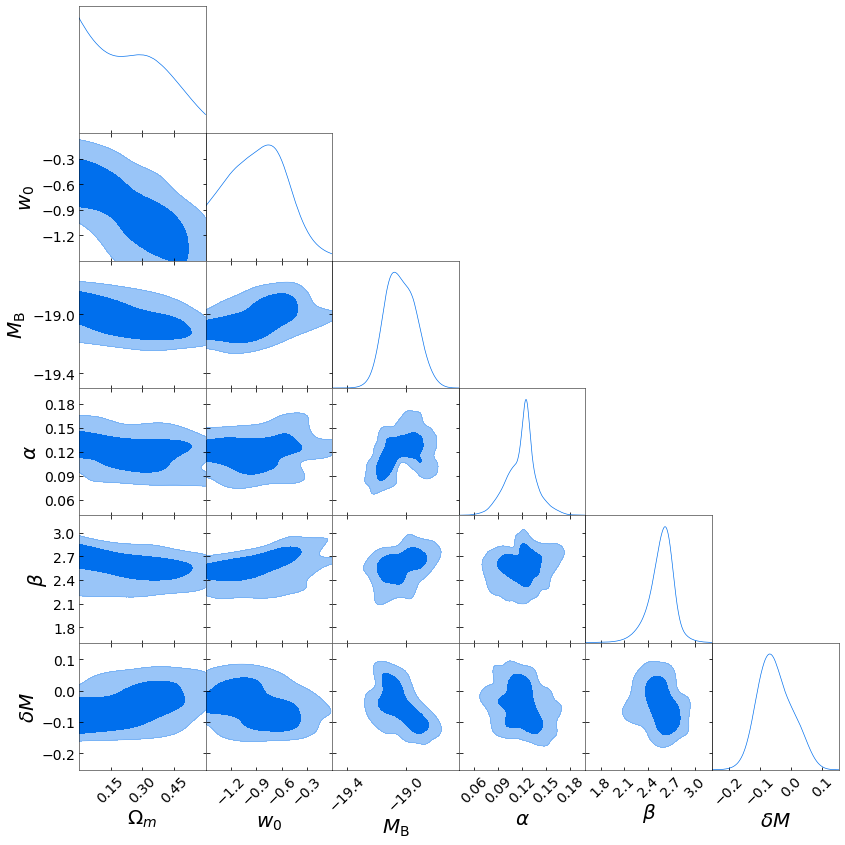

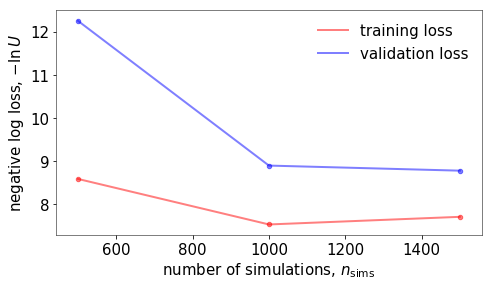

Population 3/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


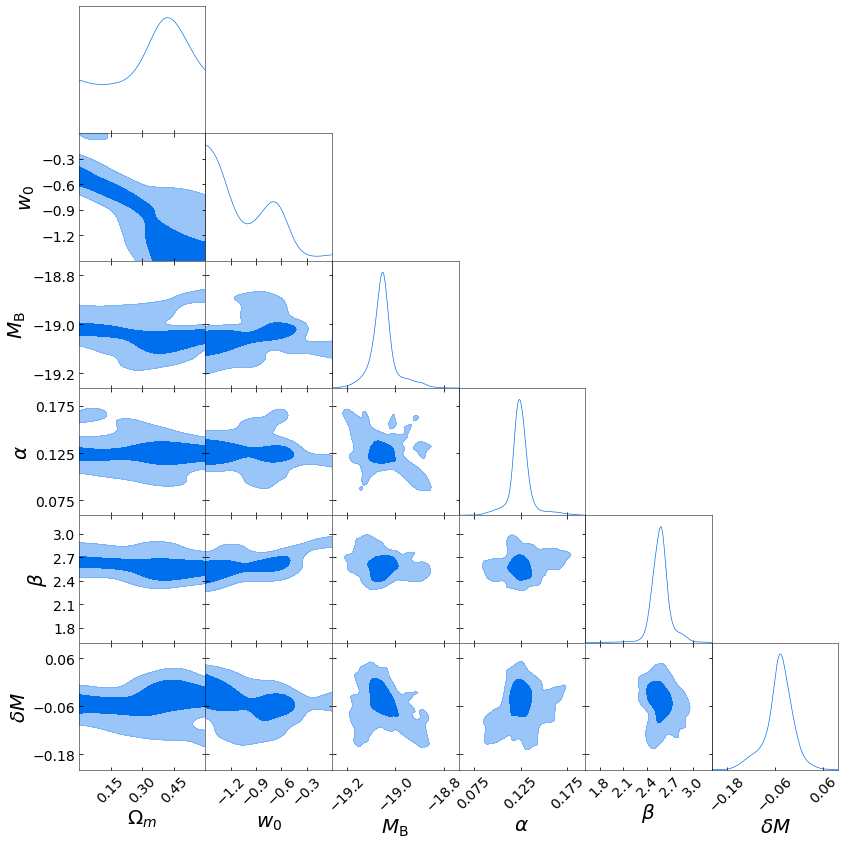

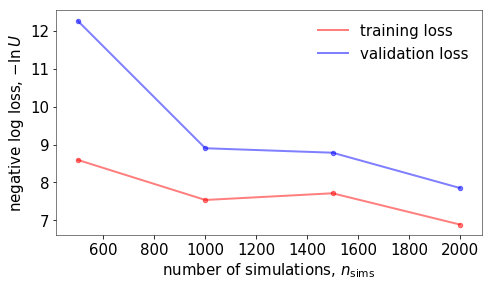

Population 4/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


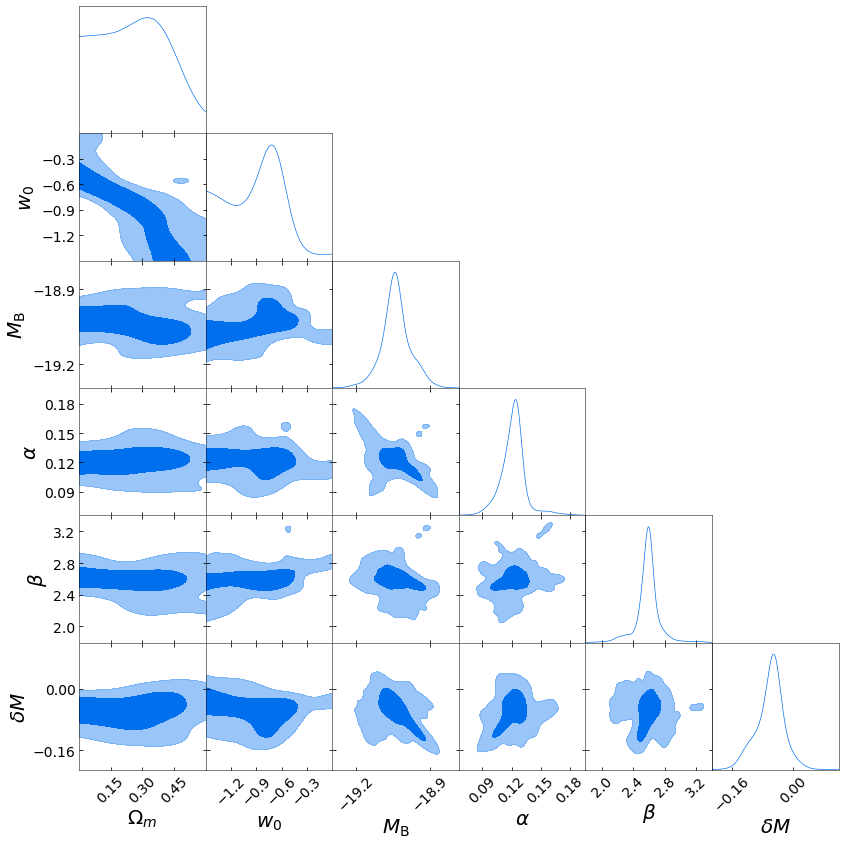

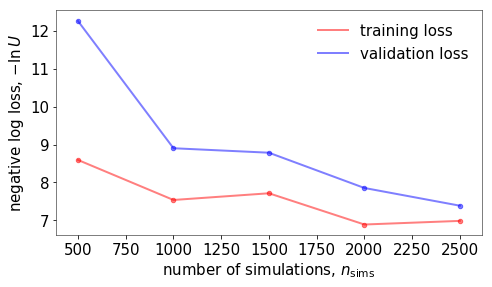

Population 5/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


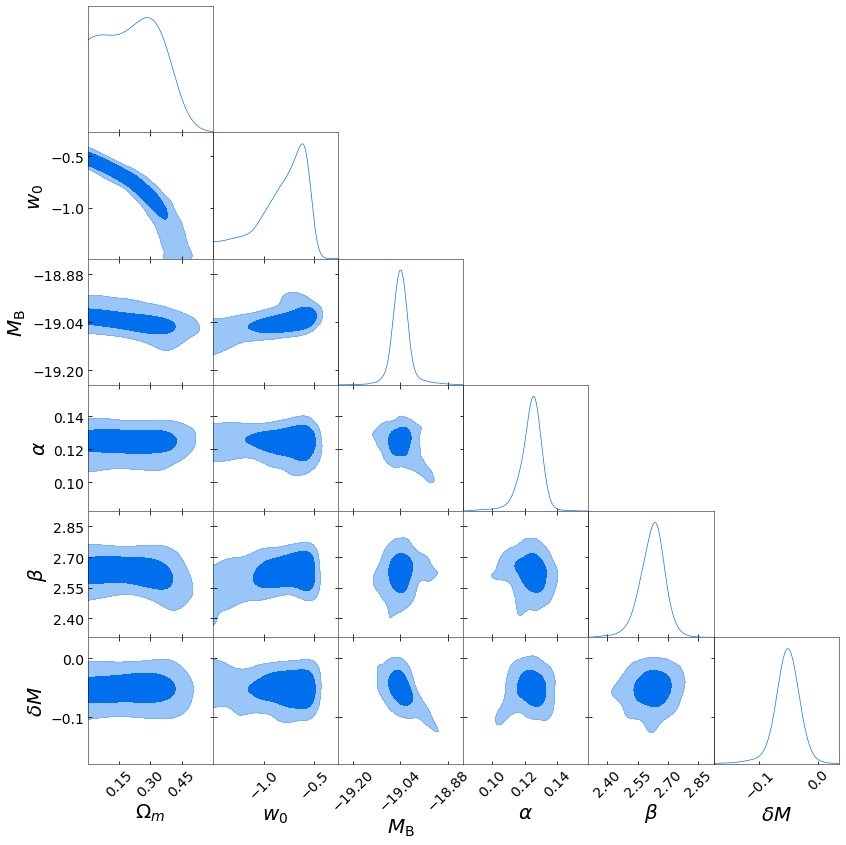

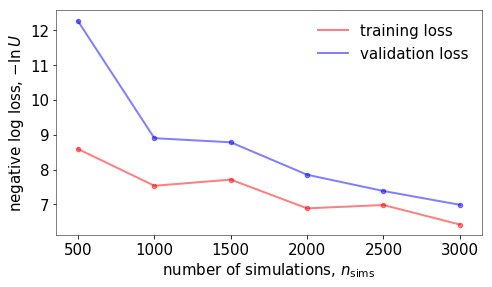

Population 6/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


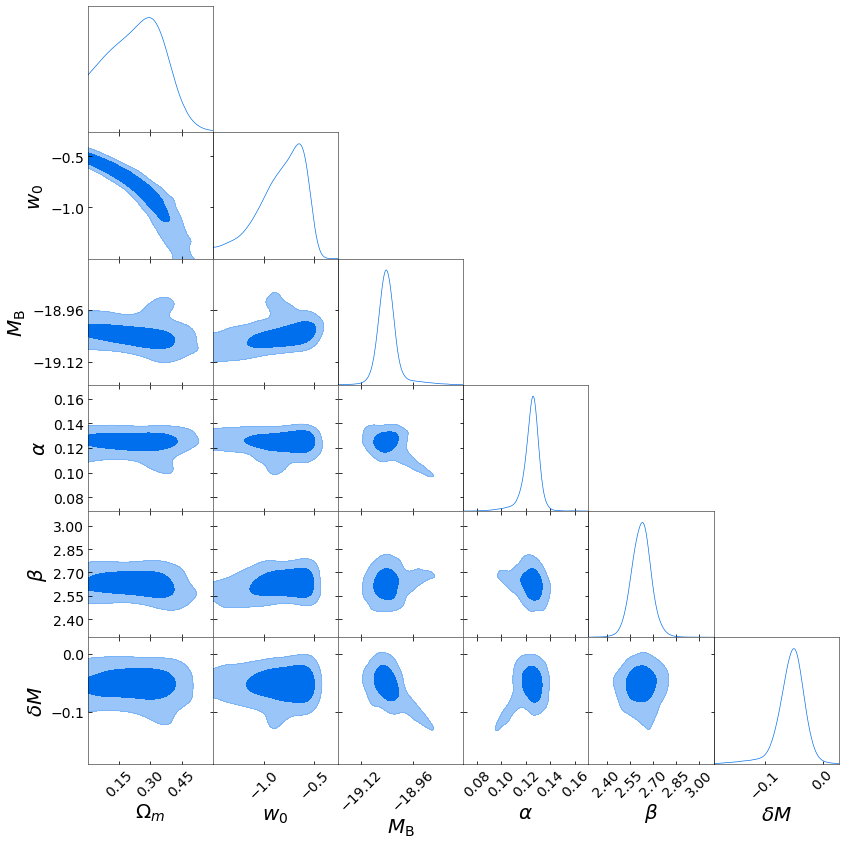

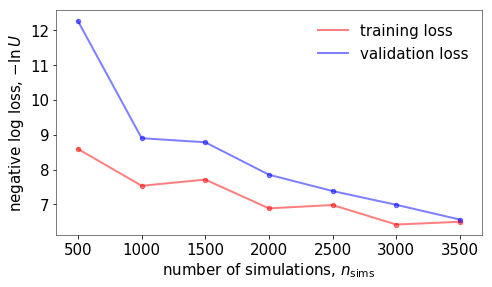

Population 7/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


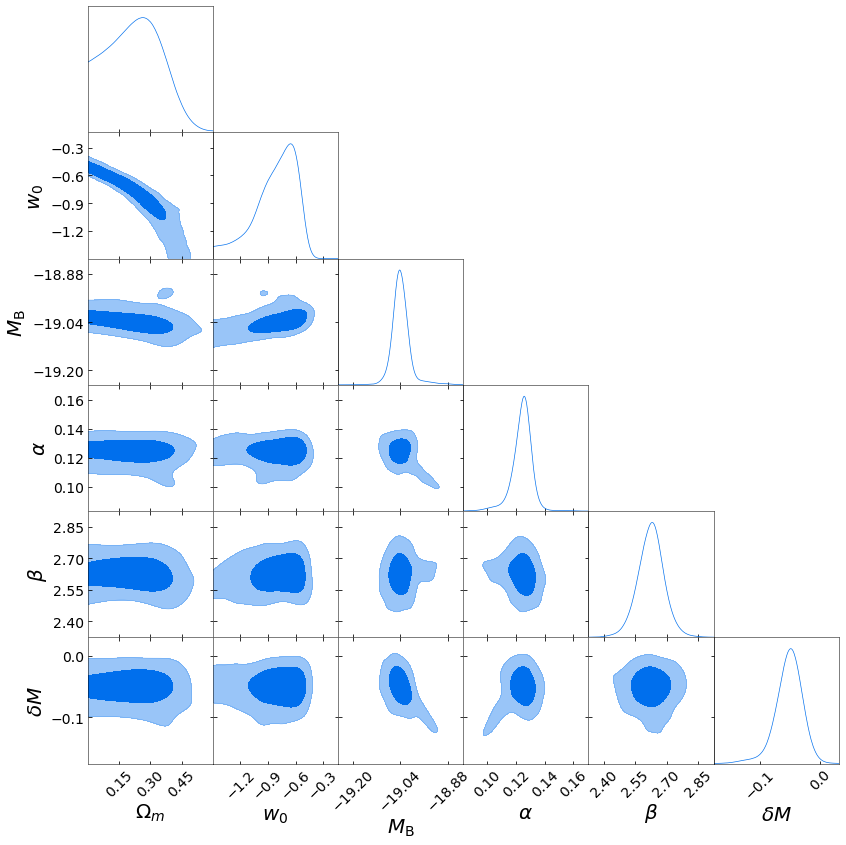

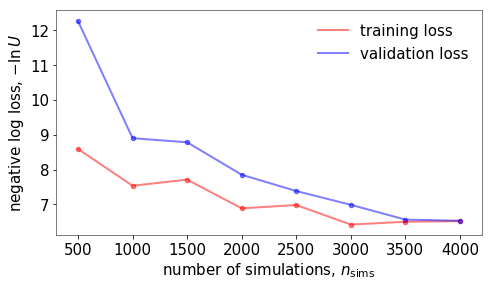

Population 8/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


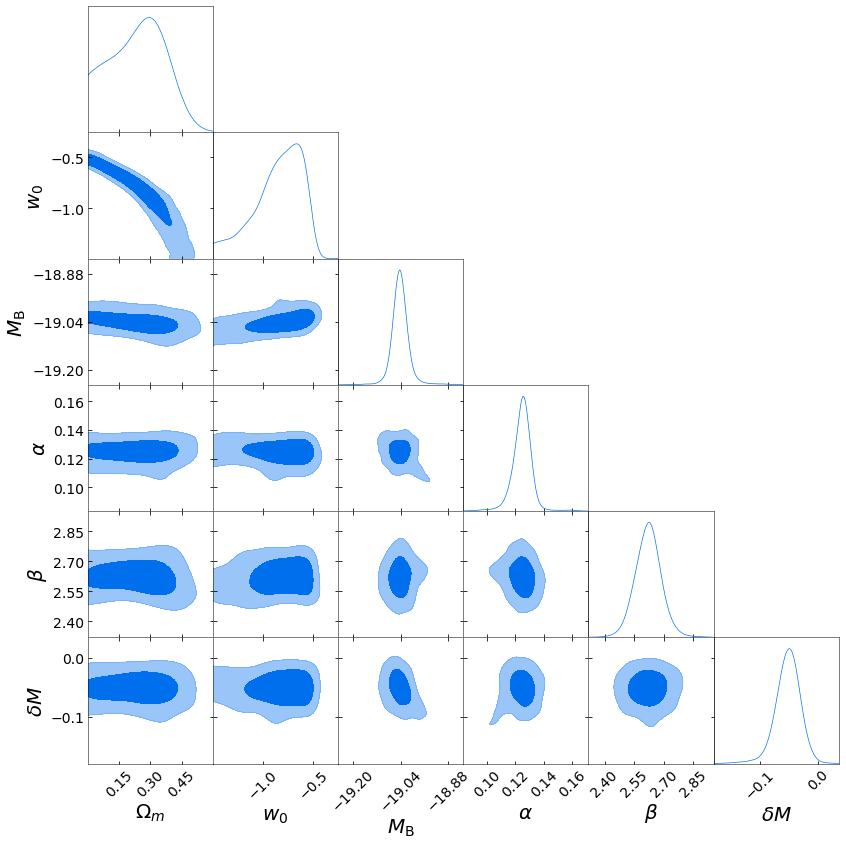

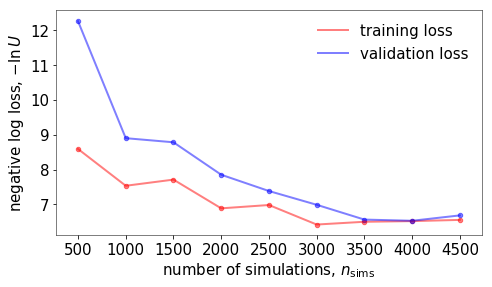

Population 9/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


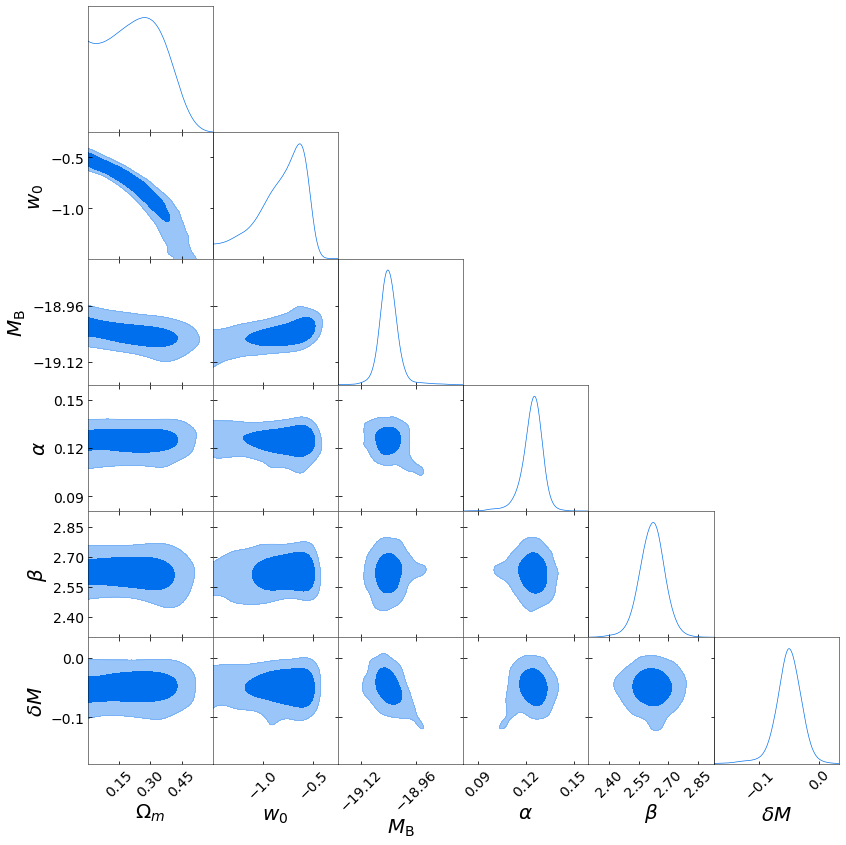

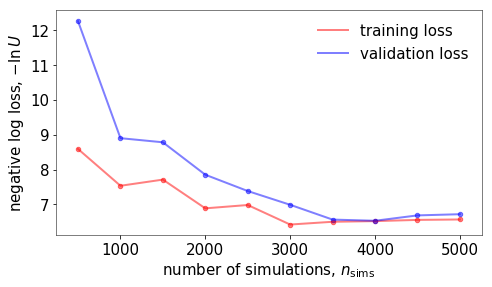

Population 10/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


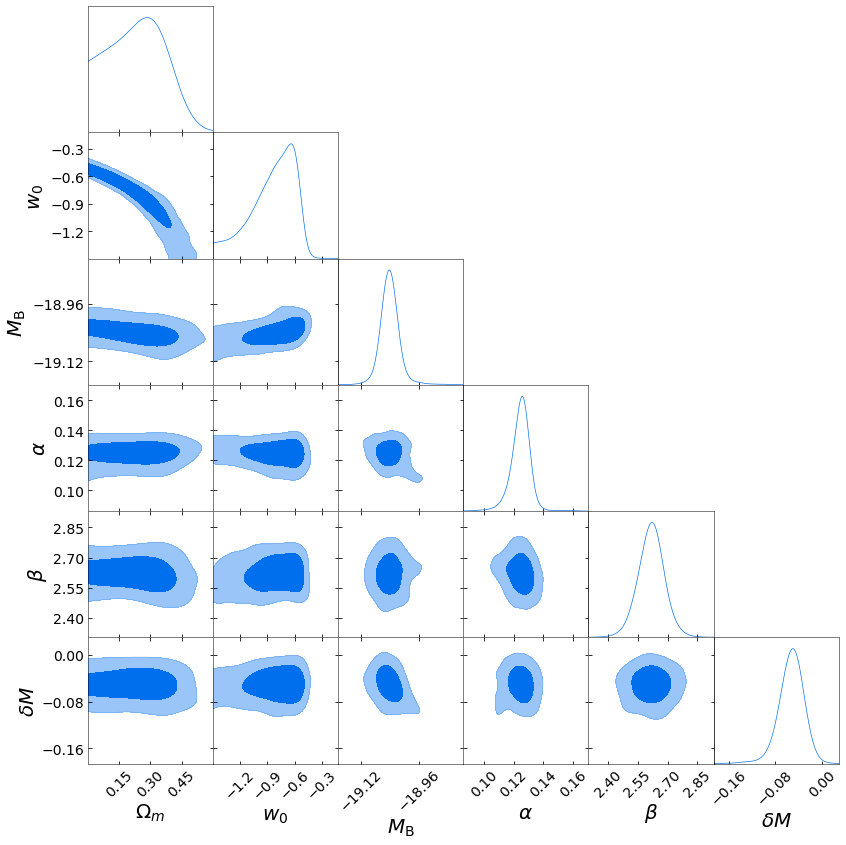

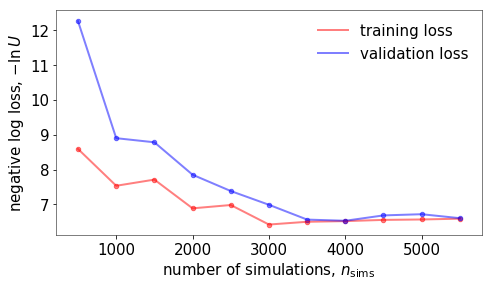

Population 11/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


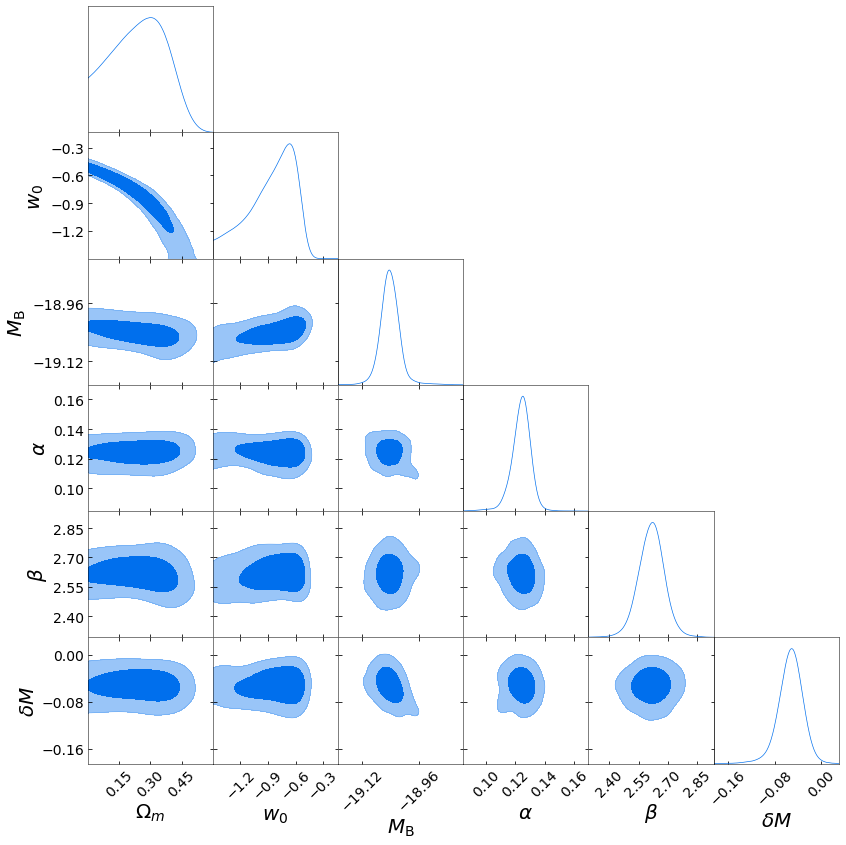

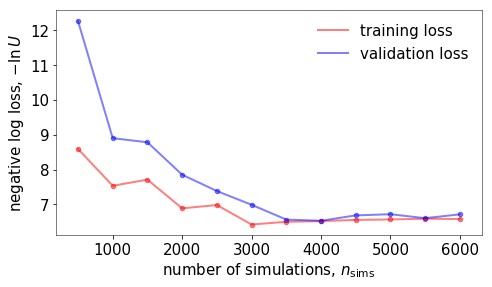

Population 12/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


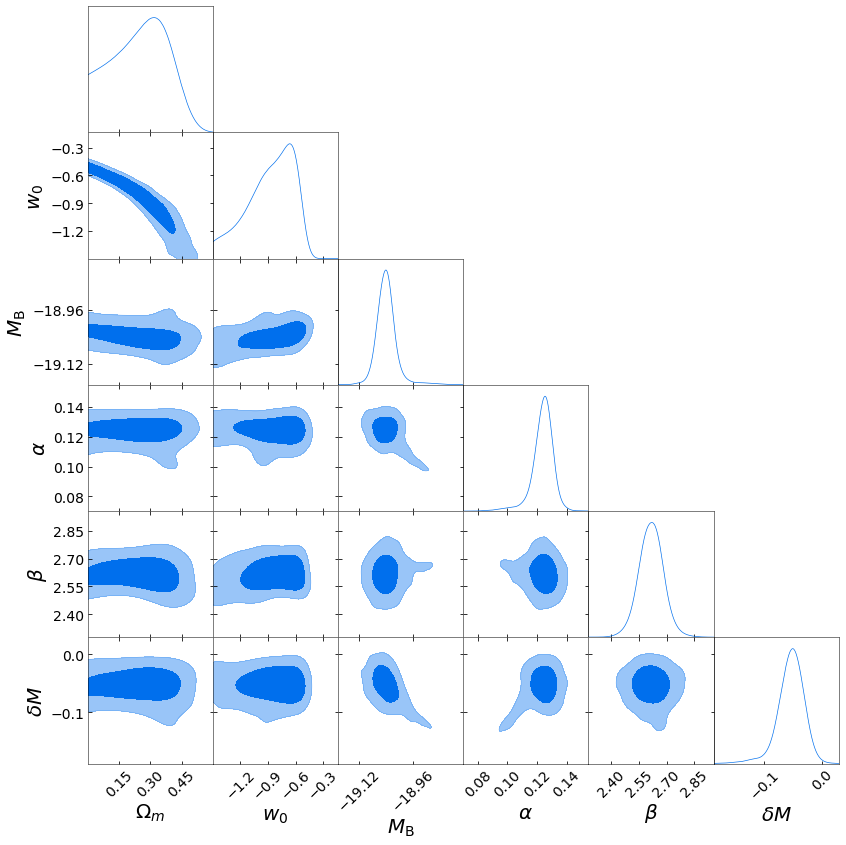

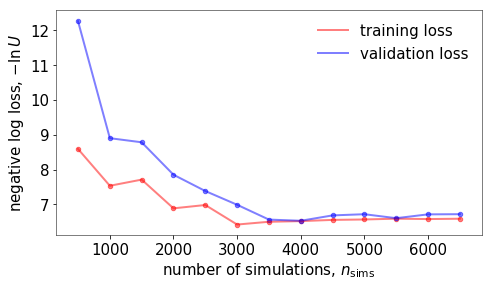

Population 13/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


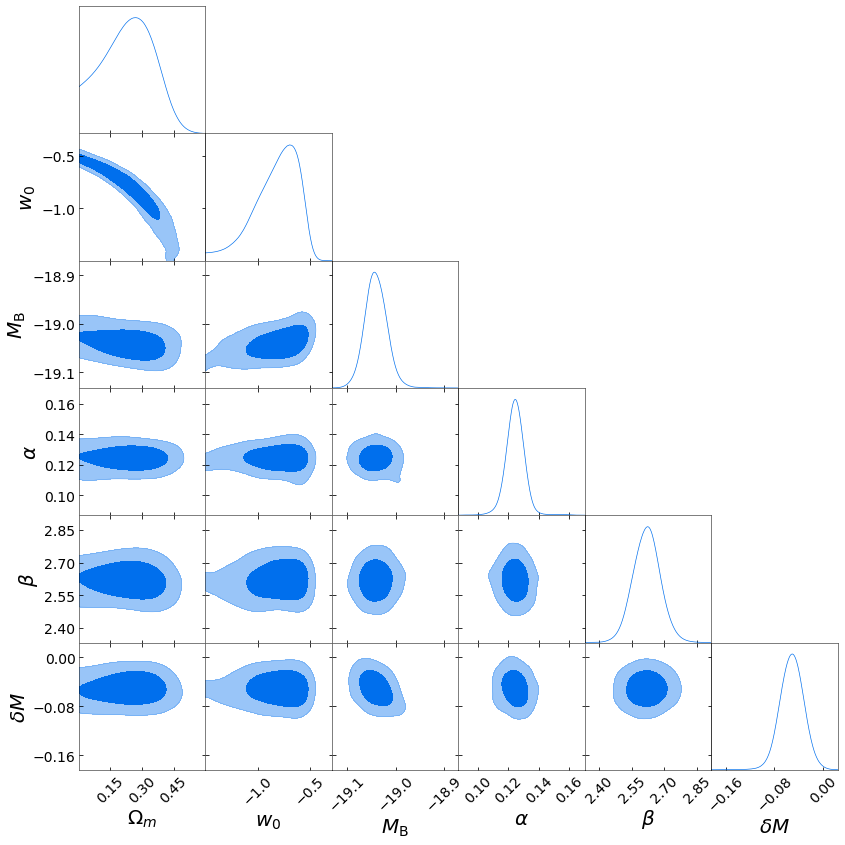

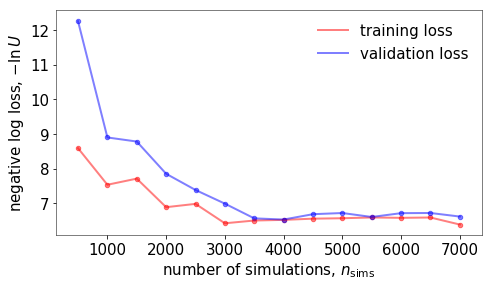

Population 14/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


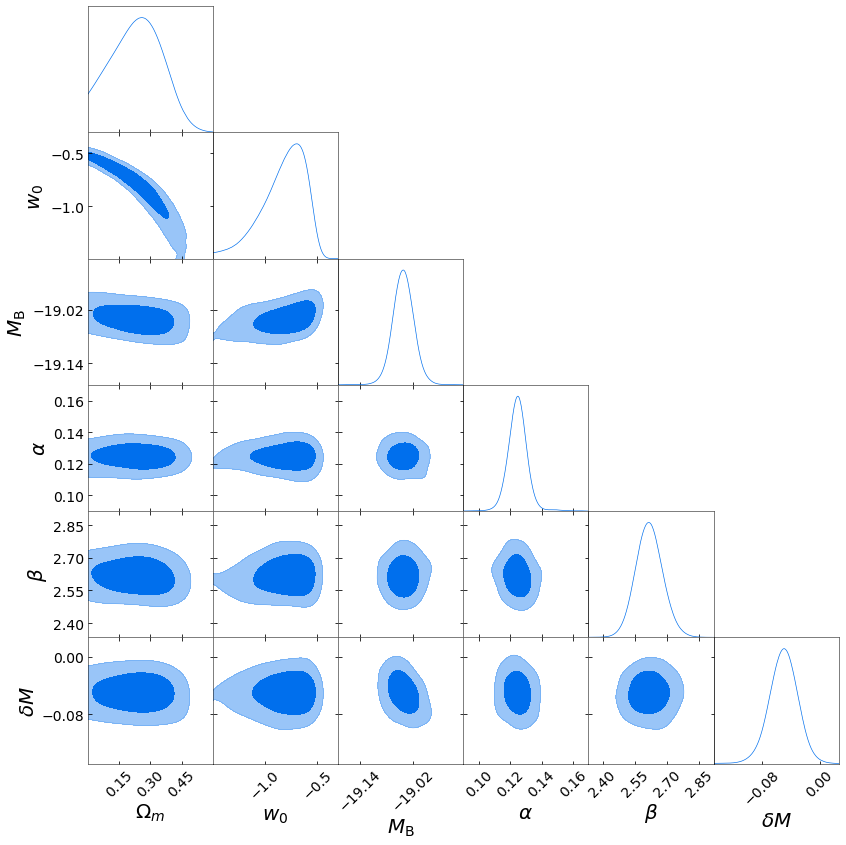

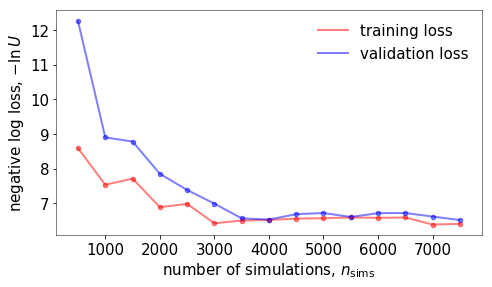

Population 15/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


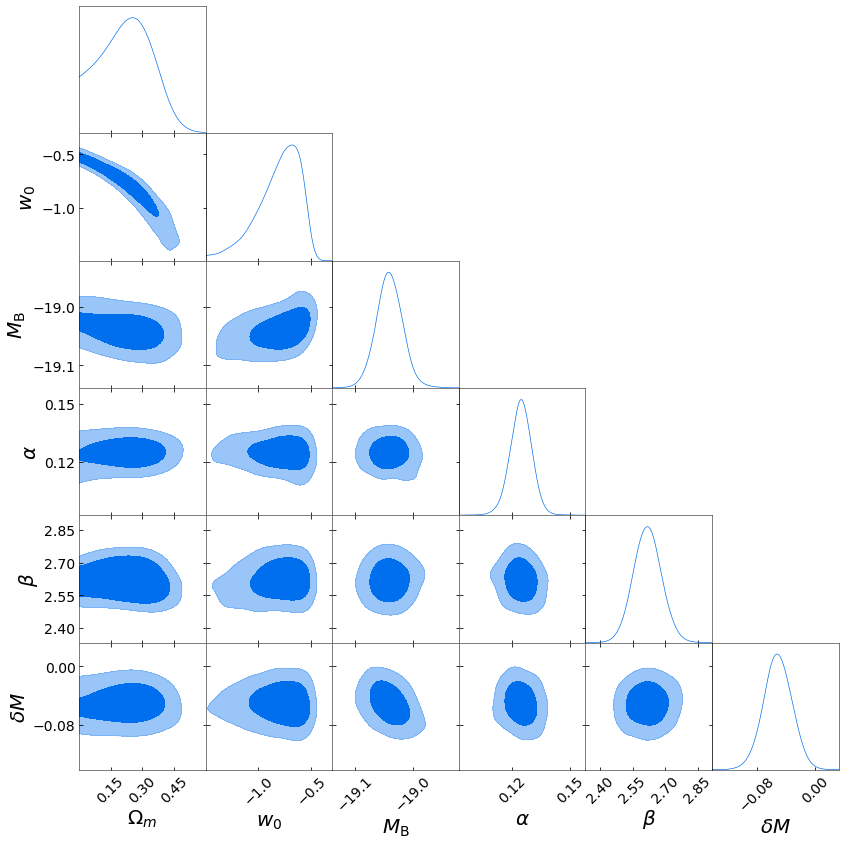

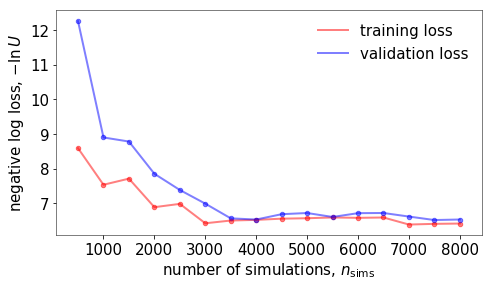

Population 16/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


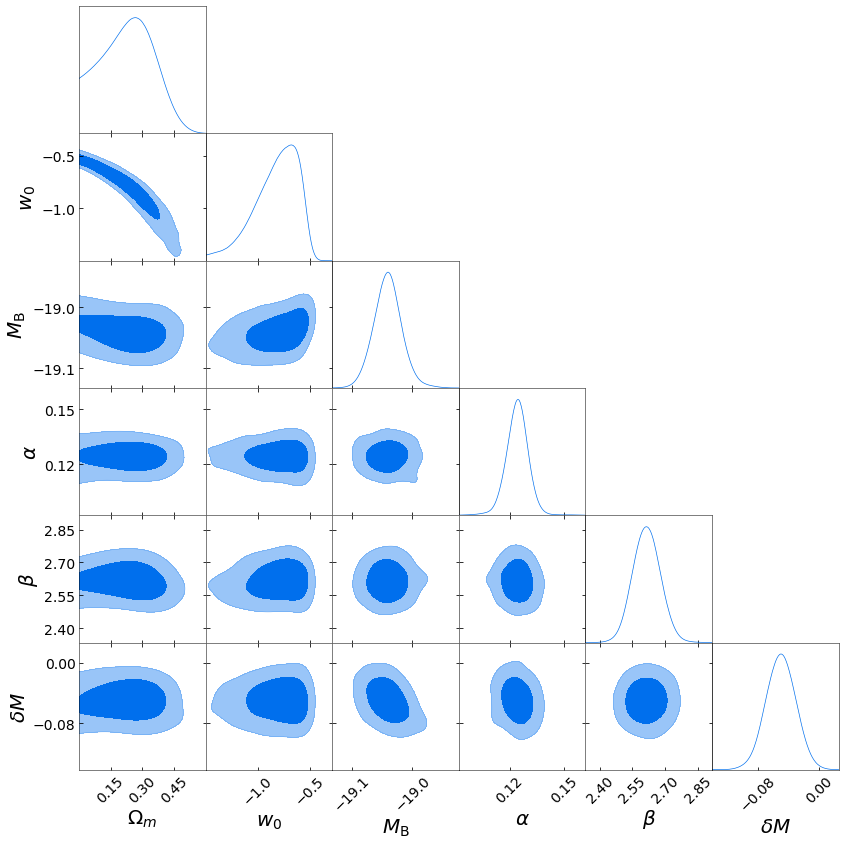

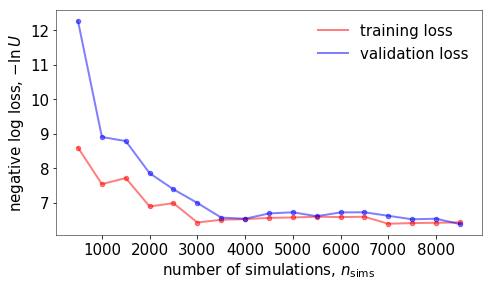

Population 17/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


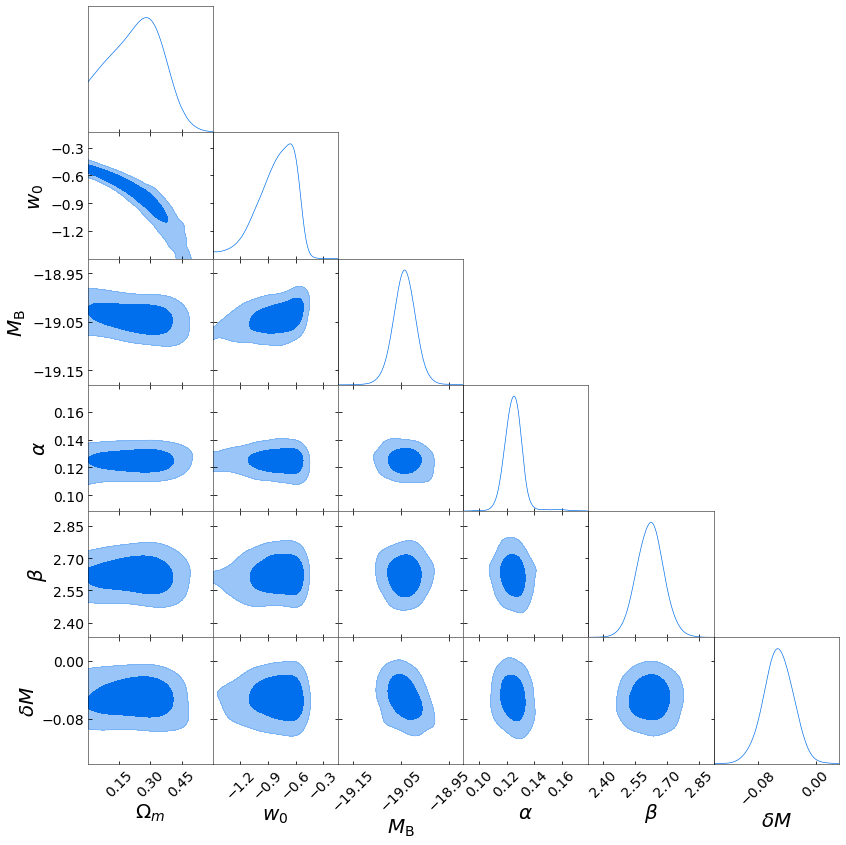

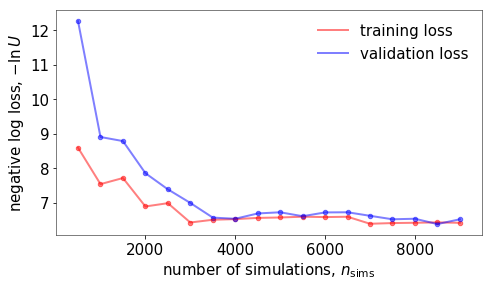

Population 18/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


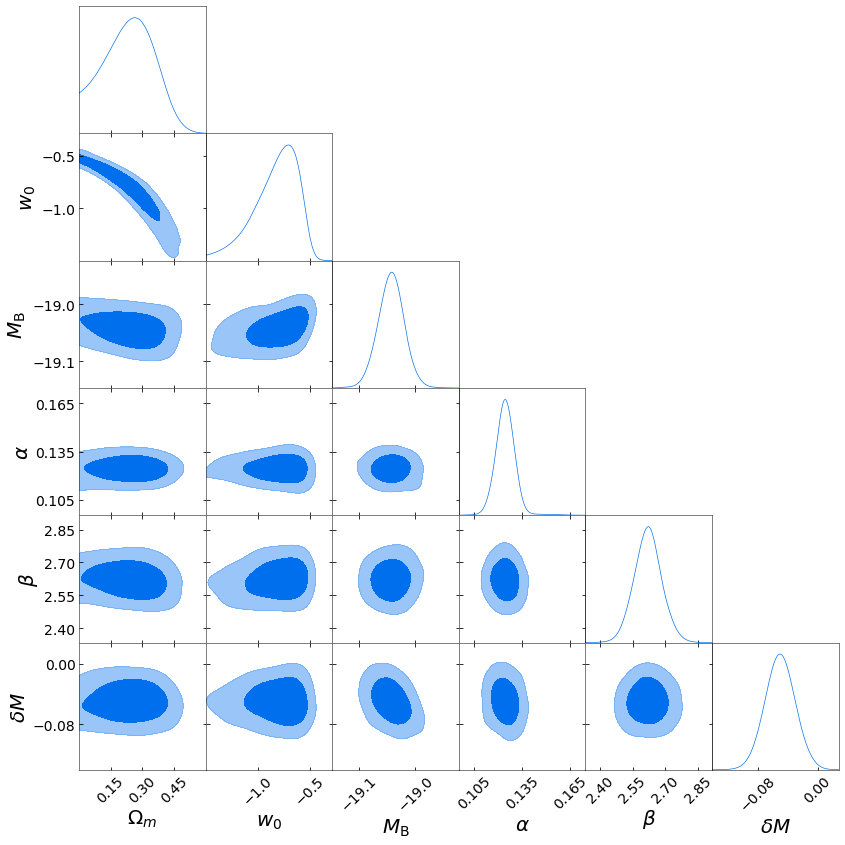

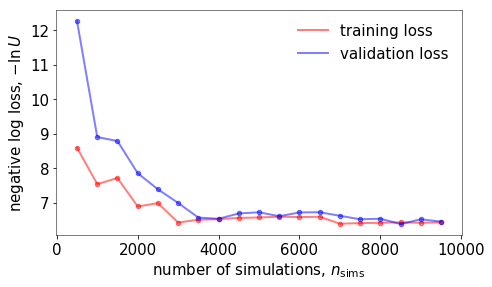

Population 19/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


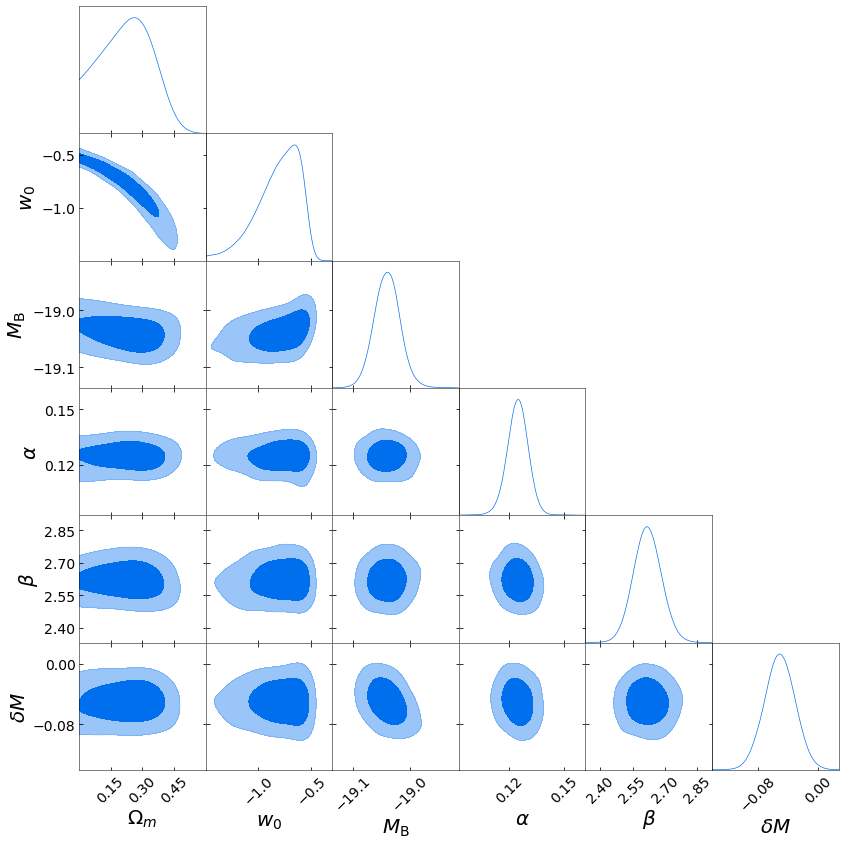

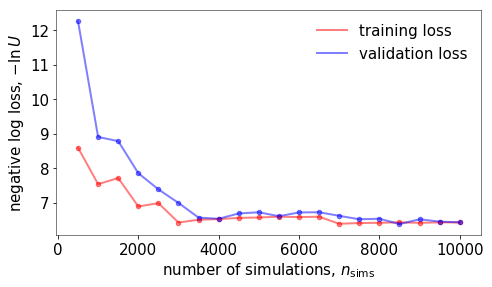

Population 20/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


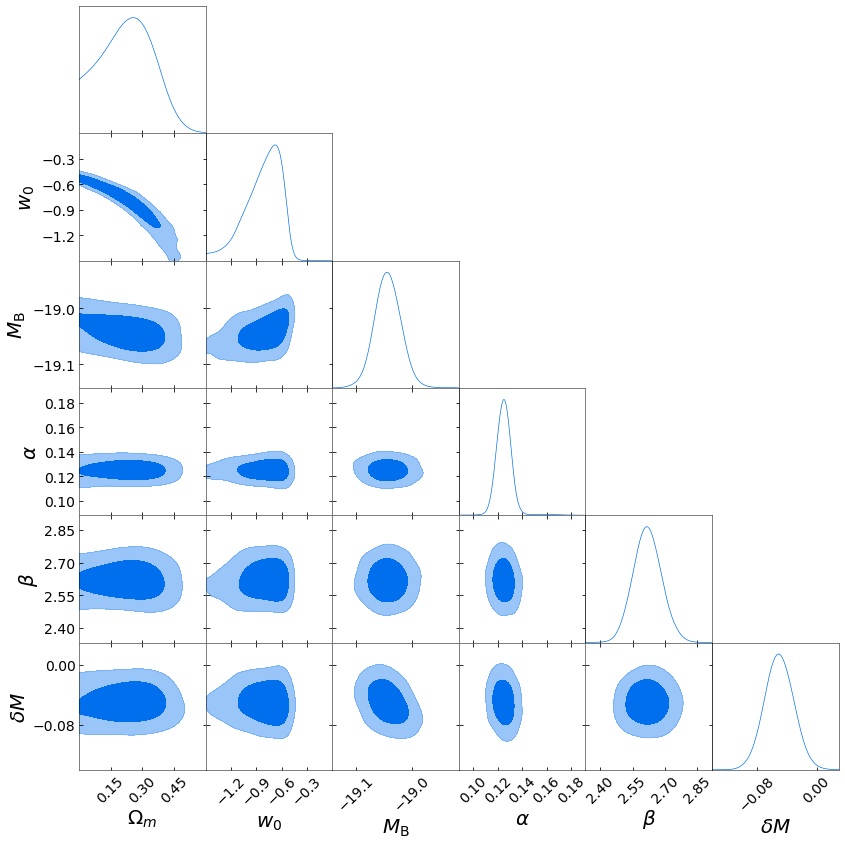

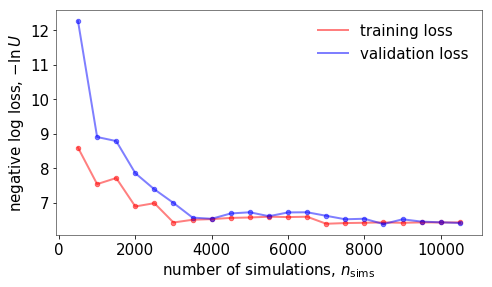

Population 21/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


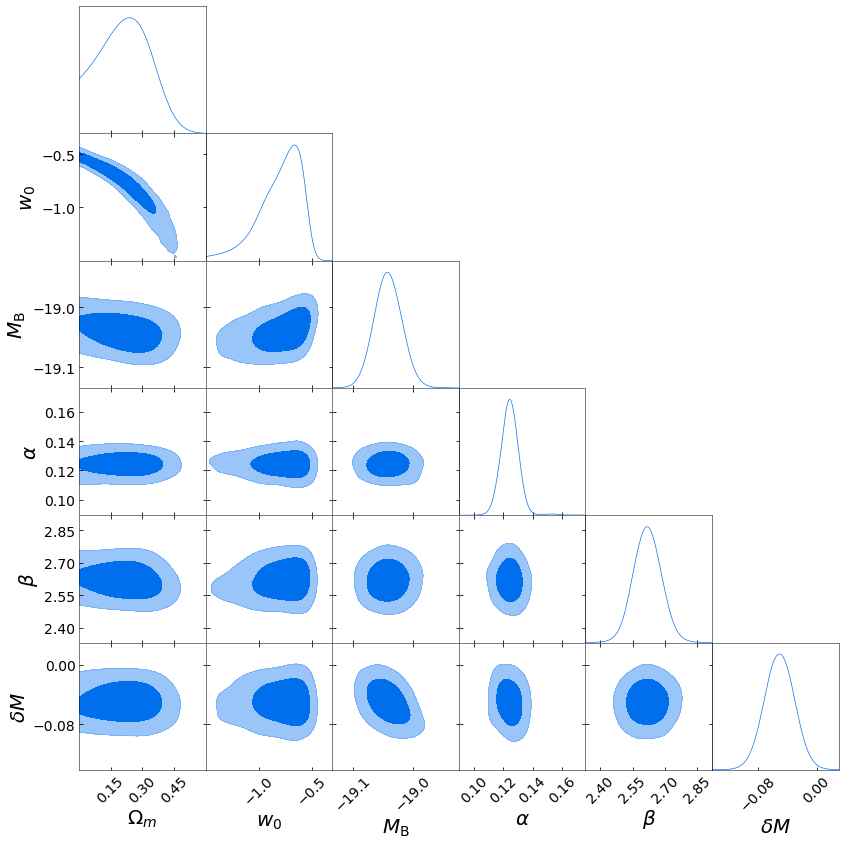

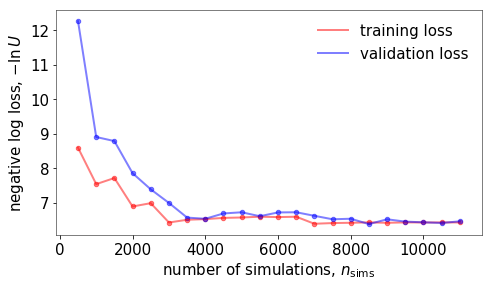

Population 22/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


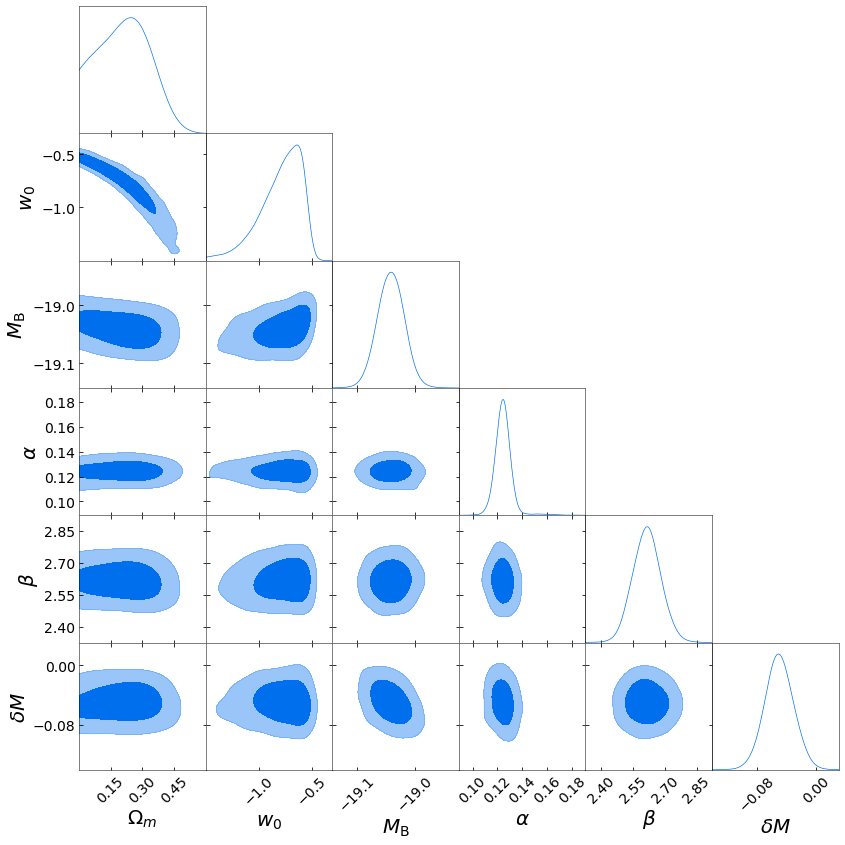

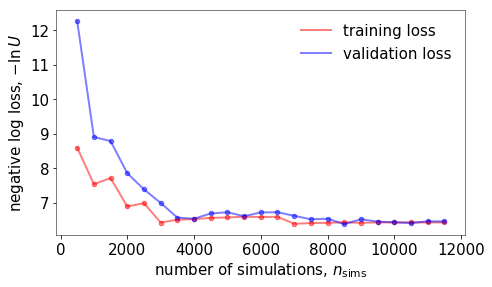

Population 23/23
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


/usr/local/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


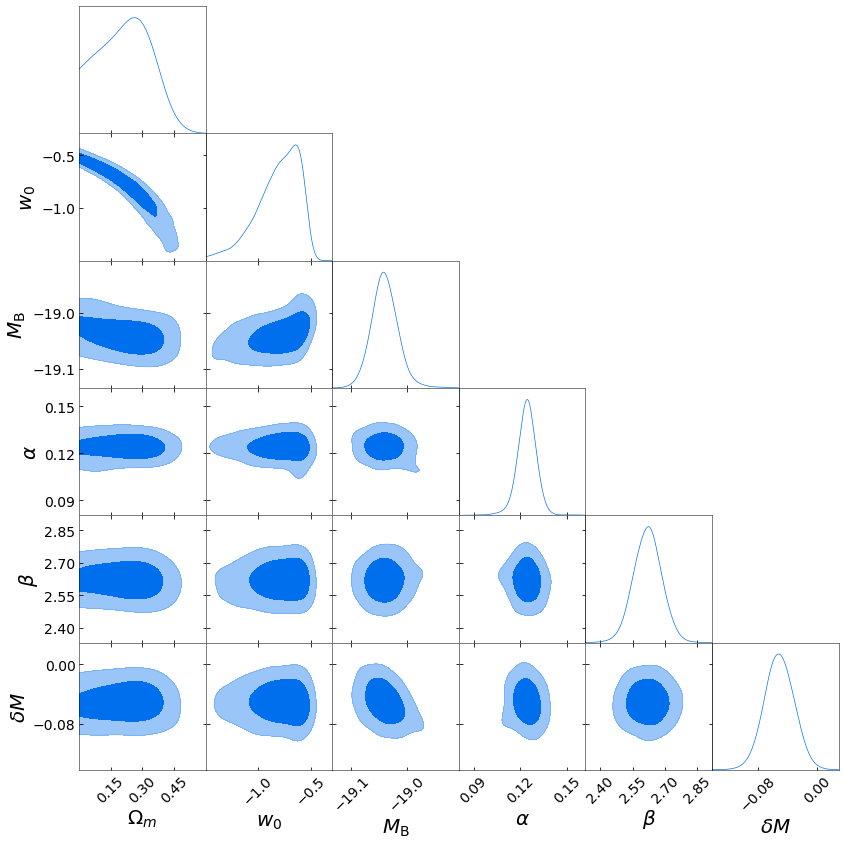

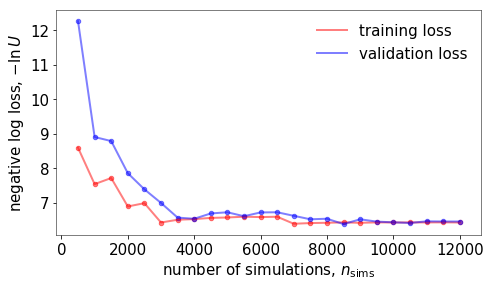

In [8]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMDN.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)

In [ ]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=6, n_outputs=6, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.DelfiMAF(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                       results_dir = "simulators/jla_supernovae/results/maf")

In [ ]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining()

In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=10)